# Baseline model for adult data

In this notebook we train a simple model on the adult data that can serve as a counterfactual for what would have happened if we hadn't made any kind of fairness intervention.

In [1]:
import joblib
from pathlib import Path

import pandas as pd
from fairlearn.metrics import (
    demographic_parity_difference,
    demographic_parity_ratio,
    equalized_odds_difference,
    equalized_odds_ratio,
)
from helpers.utils import bin_hours_per_week
from helpers.utils import (
    conditional_demographic_parity_difference,
    conditional_demographic_parity_ratio,
)
from helpers.utils import group_box_plots
from sklearn.neural_network import MLPClassifier  # noqa

Directory containing preprocessed data.

In [2]:
artifacts_dir = Path("artifacts")

Load the preprocessed data. Check out the preprocessing notebook for details on how this data was obtained.

In [3]:
data_dir = artifacts_dir / "data" / "adult"

train = pd.read_csv(data_dir / "processed" / "train.csv")
val = pd.read_csv(data_dir / "processed" / "val.csv")
test = pd.read_csv(data_dir / "processed" / "test.csv")

train_oh = pd.read_csv(data_dir / "processed" / "train-one-hot.csv")
val_oh = pd.read_csv(data_dir / "processed" / "val-one-hot.csv")
test_oh = pd.read_csv(data_dir / "processed" / "test-one-hot.csv")

In [4]:
train_oh.head()

,age,sex,capital_gain,capital_loss,hours_per_week,salary,workclass_federal_gov,workclass_local_gov,workclass_private,workclass_self_emp_inc,...,marital_status_divorced,marital_status_married_af_spouse,marital_status_married_civ_spouse,marital_status_married_spouse_absent,marital_status_never_married,marital_status_separated,marital_status_widowed,native_country_mexico,native_country_other,native_country_united_states
0,1.108936,1,-0.147741,-0.218133,2.416833,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
1,0.805386,1,-0.147741,-0.218133,2.416833,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2,-0.788255,1,-0.147741,-0.218133,-0.079269,0,0,0,1,0,...,0,0,1,0,0,0,0,0,1,0
3,1.640150,0,-0.147741,-0.218133,-0.079269,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1
4,1.108936,1,-0.147741,-0.218133,-0.079269,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,1


## Training a model to predict salary

We will load a model from disk so that results are reproducible, but commented out here is the code we used to train the model.

In [5]:
import torch
from torch.utils.data import Dataset
class AdultDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.X = torch.tensor(df.drop(columns=["salary"]).values, dtype=torch.float32)
        self.y = torch.tensor(df["salary"].values, dtype=torch.float32)
        self.s = torch.tensor(df["sex"].values, dtype=torch.int64)  # sensitive attr

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx], self.s[idx]

In [6]:
from torch.utils.data import DataLoader

train_ds = AdultDataset(train_oh)
val_ds = AdultDataset(val_oh)
test_ds = AdultDataset(test_oh)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=128)
test_loader = DataLoader(test_ds, batch_size=128)

In [7]:
import torch.nn as nn

class FairMLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.l1 = nn.Linear(input_dim, 100)
        self.l2 = nn.Linear(100, 100)
        self.l3 = nn.Linear(100, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        h1 = self.relu(self.l1(x))
        h2 = self.relu(self.l2(h1))
        out = self.sigmoid(self.l3(h2))
        return out.squeeze()

    def get_hidden(self, x):
        """Returns all hidden representations"""
        h1 = self.relu(self.l1(x))
        h2 = self.relu(self.l2(h1))
        return h1, h2

def demographic_parity_loss(y_hat, s):
    group_0 = y_hat[s == 0]
    group_1 = y_hat[s == 1]
    if len(group_0) == 0 or len(group_1) == 0:
        return torch.tensor(0.0, device=y_hat.device)
    return (group_0.mean() - group_1.mean())**2

In [8]:
lambda_list = [0.0, 0.1, 0.7, 1.0, 2.0, 10.0]
umap_results = []  # Will hold one df per λ for plotting
metrics = []       # Optional: store DP, EO, acc etc.

In [9]:
def train_model(lambda_dp, train_loader, input_dim):
    model = FairMLP(input_dim=input_dim)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    bce_loss = nn.BCELoss()

    for epoch in range(10):
        model.train()
        for x, y, s in train_loader:
            optimizer.zero_grad()
            y_hat = model(x)
            loss_base = bce_loss(y_hat, y)
            loss_fair = demographic_parity_loss(y_hat, s)
            loss = loss_base + lambda_dp * loss_fair
            loss.backward()
            optimizer.step()
    return model

In [ ]:
import umap
from sklearn.manifold import TSNE  # fallback
from sklearn.metrics import accuracy_score

model.eval()

X_test = torch.tensor(test_oh.drop(columns=["salary"]).values, dtype=torch.float32)
sensitive_attr = test_oh["sex"].values  # or race, depending on probe
y_test = test_oh["salary"].values


for lmbda in lambda_list:
    model = train_model(lmbda, train_loader, input_dim=train_oh.shape[1] - 1)
    model.eval()

    with torch.no_grad():
        h1, _ = model.get_hidden(X_test)
        h1 = h1.detach().numpy()

    reducer = umap.UMAP(n_components=2, random_state=42)
    emb = reducer.fit_transform(h1)

    df = pd.DataFrame({
        "x": emb[:, 0],
        "y": emb[:, 1],
        "gender": ["Male" if g == 1 else "Female" for g in sensitive_attr],
        "lambda": f"λ={lmbda}"
    })

    umap_results.append(df)

/Users/clarakumpel/anaconda3/envs/cil/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/clarakumpel/anaconda3/envs/cil/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/clarakumpel/anaconda3/envs/cil/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/clarakumpel/anaconda3/envs/cil/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/clarakumpel/anaconda3/envs/cil/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 

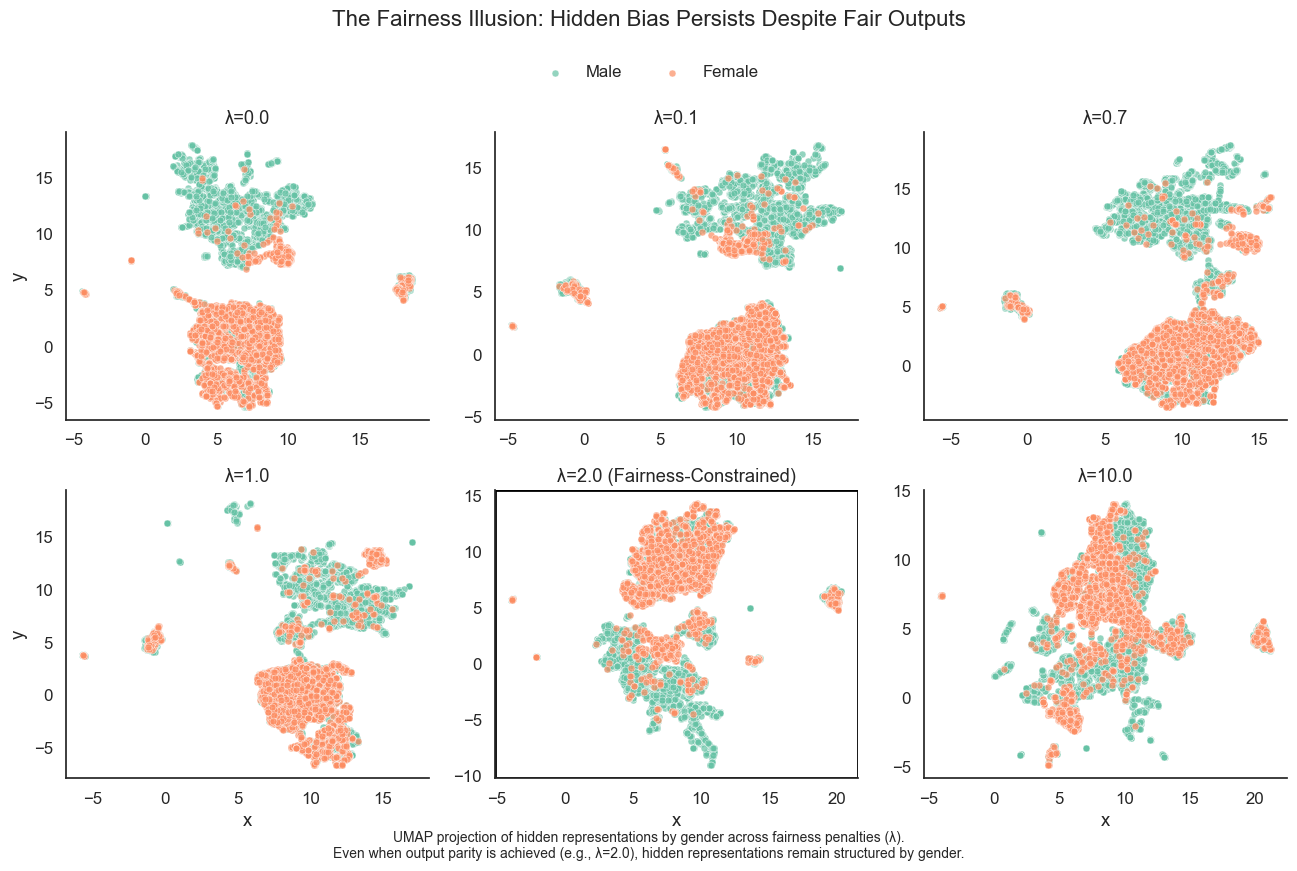

In [32]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

df_all = pd.concat(umap_results, ignore_index=True)

import seaborn as sns
sns.set(style="white", font_scale=1.1)

gender_labels = ["Male" if g == 1 else "Female" for g in sensitive_attr]
highlight_lambda = "λ=2.0"  # or whatever is your main result


g = sns.FacetGrid(df_all, col="lambda", hue="gender", height=4, col_wrap=3, palette="Set2", sharex=False, sharey=False)
g.map_dataframe(sns.scatterplot, x="x", y="y", alpha=0.7, s=25)
g.add_legend(title="Gender")


title_map = {
    f"λ={l}": f"λ={l}" if l != 2.0 else "λ=2.0 (Fairness-Constrained)"
    for l in lambda_list
}
for ax, label in zip(g.axes.flat, g.col_names):
    ax.set_title(title_map[label], fontsize=11)

# Add bounding box highlight around λ=2.0
for ax, title in zip(g.axes.flat, g.col_names):
    if title == highlight_lambda:
        # Highlight box
        ax.add_patch(Rectangle(
            (ax.get_xlim()[0], ax.get_ylim()[0]),
            ax.get_xlim()[1] - ax.get_xlim()[0],
            ax.get_ylim()[1] - ax.get_ylim()[0],
            linewidth=2, edgecolor='black', facecolor='none'
        ))

# After g.map_dataframe(...)
# Update titles cleanly all at once:
new_titles = [t if t != highlight_lambda else f"{highlight_lambda} (Fairness-Constrained)"
              for t in g.col_names]
for ax, new_title in zip(g.axes.flat, new_titles):
    ax.set_title(new_title)

sns.move_legend(
    g, "upper center",
    bbox_to_anchor=(0.5, 1.0),  # push it between figure and title
    ncol=2, title=None, frameon=False
)


# Annotate figure title
plt.suptitle("The Fairness Illusion: Hidden Bias Persists Despite Fair Outputs", fontsize=16, y=1.05)

# Optionally: add caption/annotation outside of plots
plt.figtext(0.5, -0.01,
    "UMAP projection of hidden representations by gender across fairness penalties (λ).\n"
    "Even when output parity is achieved (e.g., λ=2.0), hidden representations remain structured by gender.",
    ha="center", fontsize=10)



plt.tight_layout()
plt.show()

In [ ]:
import matplotlib as mpl
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.labelsize'] = 25
mpl.rcParams['axes.titlesize'] = 25
mpl.rcParams['xtick.labelsize'] = 25
mpl.rcParams['ytick.labelsize'] = 25
mpl.rcParams['legend.fontsize'] = 29

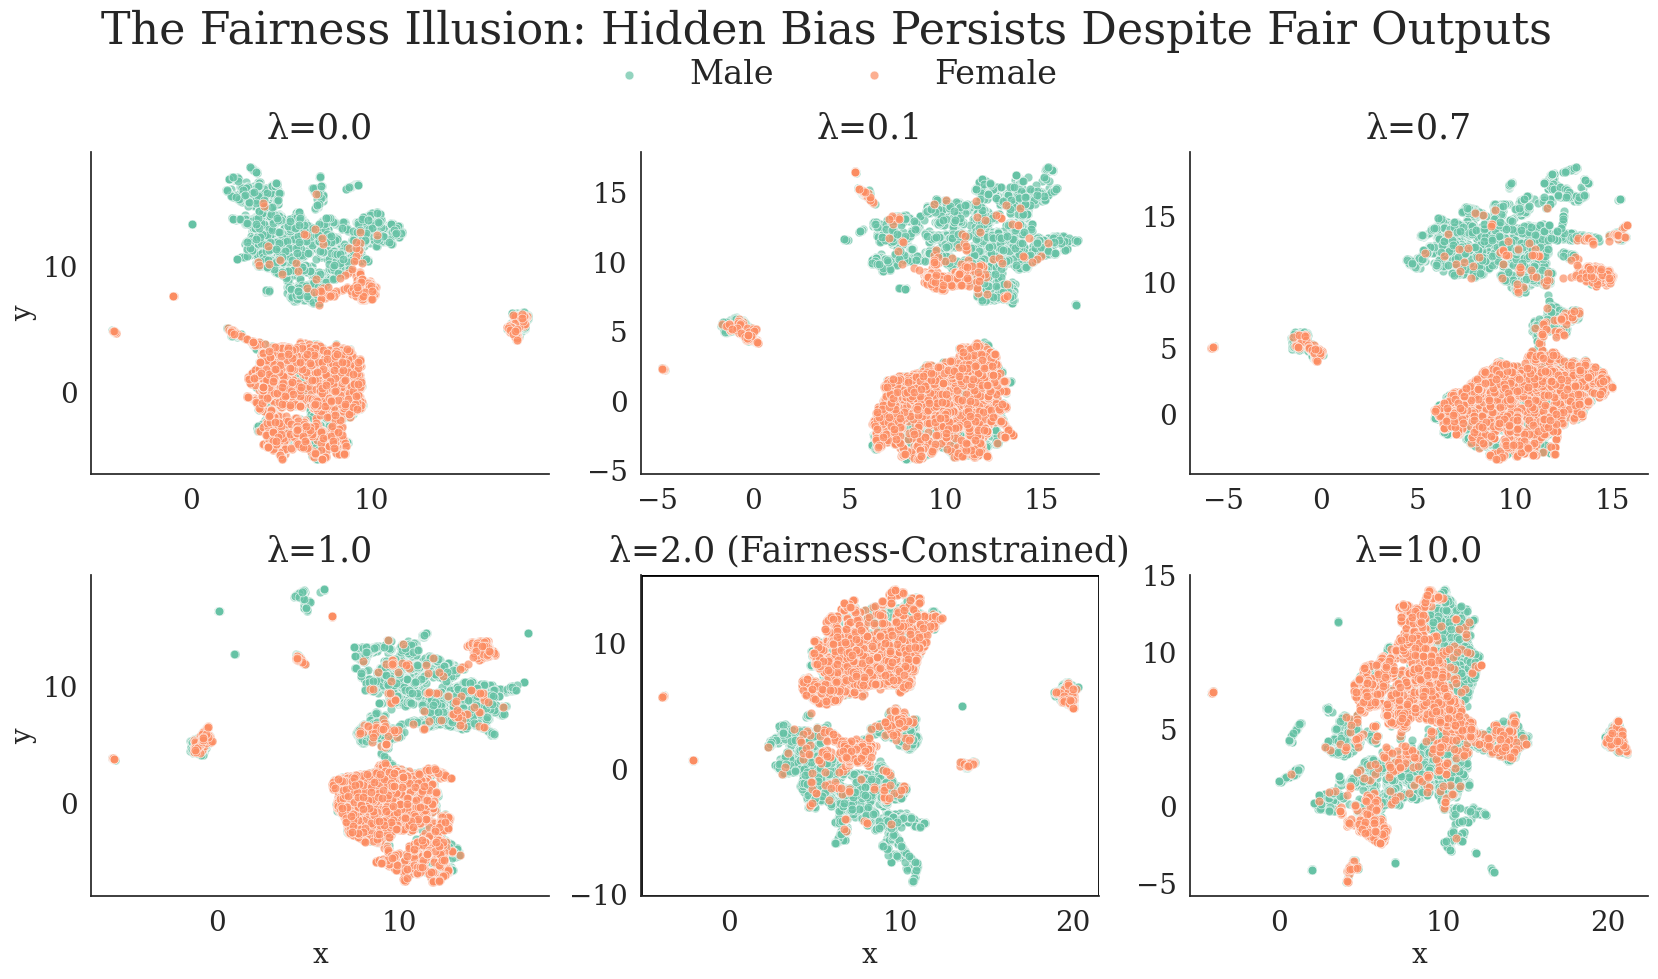

In [54]:
g = sns.FacetGrid(
    df_all, col="lambda", hue="gender", height=4.8, col_wrap=3,
    palette="Set2", sharex=False, sharey=False
)
g.map_dataframe(sns.scatterplot, x="x", y="y", alpha=0.7, s=40)  # bigger dots
g.add_legend(title="Gender")

# Set subplot titles with larger font
for ax, label in zip(g.axes.flat, g.col_names):
    title = f"{label} (Fairness-Constrained)" if label == "λ=2.0" else label
    ax.set_title(title, fontsize=25, pad=10)  # pad lowers the title

# Highlight λ=2.0
for ax, label in zip(g.axes.flat, g.col_names):
    if label == "λ=2.0":
        ax.add_patch(Rectangle(
            (ax.get_xlim()[0], ax.get_ylim()[0]),
            ax.get_xlim()[1] - ax.get_xlim()[0],
            ax.get_ylim()[1] - ax.get_ylim()[0],
            linewidth=2, edgecolor='black', facecolor='none'
        ))

# Move legend under title
sns.move_legend(
    g, "upper center",
    bbox_to_anchor=(0.5, 1.0), ncol=2, title=None, frameon=False
)

# Bigger figure title
# Centered, large title with tighter spacing
plt.subplots_adjust(top=0.88)
plt.suptitle("The Fairness Illusion: Hidden Bias Persists Despite Fair Outputs",
             fontsize=32, y=1.02)
# Caption below
# plt.figtext(0.5, -0.05,
#     "UMAP projection of hidden representations by gender across fairness penalties (λ).\n"
#     "Even when output parity is achieved (e.g., λ=2.0), hidden representations remain structured by gender.",
#     ha="center", fontsize=26)

# High-resolution export option
plt.tight_layout()
plt.savefig("fairness_illusion_umap.png", dpi=300, bbox_inches="tight")
plt.show()

In [26]:
# test whether you can predict 2 from 1
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

sex = test_oh["sex"].values

# Train/test split (use same indices for all)
X_train, X_val, y_train, y_val = train_test_split(h1, sex, test_size=0.3, stratify=sex, random_state=42)

# Train logistic regression on h1
probe = LogisticRegression(
    penalty='l2',
    C=1.0,
    max_iter=1000,
    class_weight='balanced'
)
probe.fit(X_train, y_train)

acc_h1 = accuracy_score(y_val, probe.predict(X_val))
print(f"Probe accuracy on layer 1 (same layer): {acc_h1:.3f}")

# Use same validation indices from above
_, h2_val, _, y_val_check = train_test_split(h2, sex, test_size=0.3, stratify=sex, random_state=42)
assert (y_val == y_val_check).all()

acc_h2_cross = accuracy_score(y_val, probe.predict(h2_val))
print(f"Probe accuracy on layer 2 (cross-layer): {acc_h2_cross:.3f}")

Probe accuracy on layer 1 (same layer): 0.996
Probe accuracy on layer 2 (cross-layer): 0.357


In [29]:
sensitive_attr = test_oh["sex"].values  # or any binary attribute

# Step 1: Fixed validation split indices
train_idx, val_idx = train_test_split(
    np.arange(len(sensitive_attr)), test_size=0.3, stratify=sensitive_attr, random_state=42
)

# Helper function
def train_probe_on(h_train, y_train):
    probe = LogisticRegression(
        penalty='l2', C=1.0, max_iter=1000, class_weight='balanced'
    )
    probe.fit(h_train, y_train)
    return probe

# Step 2: Split data
h1_train, h1_val = h1[train_idx], h1[val_idx]
h2_train, h2_val = h2[train_idx], h2[val_idx]
y_train, y_val = sensitive_attr[train_idx], sensitive_attr[val_idx]

# Step 3: Train two probes
probe_l1 = train_probe_on(h1_train, y_train)
probe_l2 = train_probe_on(h2_train, y_train)

# Step 4: Evaluate on both layers
acc = np.zeros((2, 2))

acc[0, 0] = accuracy_score(y_val, probe_l1.predict(h1_val))  # L1→L1
acc[0, 1] = accuracy_score(y_val, probe_l1.predict(h2_val))  # L1→L2
acc[1, 0] = accuracy_score(y_val, probe_l2.predict(h1_val))  # L2→L1
acc[1, 1] = accuracy_score(y_val, probe_l2.predict(h2_val))  # L2→L2

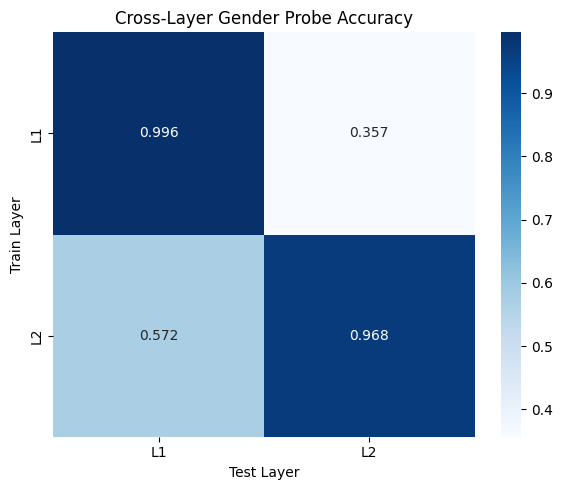

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(6, 5))
sns.heatmap(acc, annot=True, fmt=".3f", cmap="Blues",
            xticklabels=["L1", "L2"], yticklabels=["L1", "L2"])
plt.xlabel("Test Layer")
plt.ylabel("Train Layer")
plt.title("Cross-Layer Gender Probe Accuracy")
plt.tight_layout()
plt.show()

In [32]:
np.random.seed(42)  # for reproducibility
random_labels = np.random.randint(0, 2, size=len(h1))  # shape: (N,)
train_idx, val_idx = train_test_split(
    np.arange(len(random_labels)), test_size=0.3, stratify=random_labels, random_state=42
)

h1_train, h1_val = h1[train_idx], h1[val_idx]
h2_train, h2_val = h2[train_idx], h2[val_idx]
y_train, y_val = random_labels[train_idx], random_labels[val_idx]
def train_and_eval_probe(h_train, h_val, y_train, y_val):
    probe = LogisticRegression(
        penalty='l2', C=1.0, max_iter=1000, class_weight='balanced'
    )
    probe.fit(h_train, y_train)
    acc = accuracy_score(y_val, probe.predict(h_val))
    return acc

acc_null_h1 = train_and_eval_probe(h1_train, h1_val, y_train, y_val)
acc_null_h2 = train_and_eval_probe(h2_train, h2_val, y_train, y_val)

print(f"Null probe accuracy on layer 1: {acc_null_h1:.3f}")
print(f"Null probe accuracy on layer 2: {acc_null_h2:.3f}")

Null probe accuracy on layer 1: 0.491
Null probe accuracy on layer 2: 0.500


In [ ]:
sensitive_attr = test_oh["sex"].values  # or any binary attribute

# Step 1: Fixed validation split indices
train_idx, val_idx = train_test_split(
    np.arange(len(sensitive_attr)), test_size=0.3, stratify=sensitive_attr, random_state=42
)

# Helper function
def train_probe_on(h_train, y_train):
    probe = LogisticRegression(
        penalty='l2', C=1.0, max_iter=1000, class_weight='balanced'
    )
    probe.fit(h_train, y_train)
    return probe

# Step 2: Split data
h1_train, h1_val = h1[train_idx], h1[val_idx]
h2_train, h2_val = h2[train_idx], h2[val_idx]
y_train, y_val = sensitive_attr[train_idx], sensitive_attr[val_idx]

# Step 3: Train two probes
probe_l1 = train_probe_on(h1_train, y_train)
probe_l2 = train_probe_on(h2_train, y_train)

# Step 4: Evaluate on both layers
acc = np.zeros((2, 2))

acc[0, 0] = accuracy_score(y_val, probe_l1.predict(h1_val))  # L1→L1
acc[0, 1] = accuracy_score(y_val, probe_l1.predict(h2_val))  # L1→L2
acc[1, 0] = accuracy_score(y_val, probe_l2.predict(h1_val))  # L2→L1
acc[1, 1] = accuracy_score(y_val, probe_l2.predict(h2_val))  # L2→L2

In [24]:
def train_probe(h, s):
    X_train, X_val, y_train, y_val = train_test_split(h, s, test_size=0.3, stratify=s)
    probe = LogisticRegression(
        penalty='l2',
        C=1.0,
        max_iter=1000,
        class_weight='balanced'
    )
    probe.fit(X_train, y_train)
    acc = accuracy_score(y_val, probe.predict(X_val))
    return acc

In [17]:
acc_h1 = train_probe(h1, sensitive_attr)
acc_h2 = train_probe(h2, sensitive_attr)
acc_h3 = train_probe(h3, sensitive_attr)

print(f"Probe accuracy from layer 1: {acc_h1:.3f}")
print(f"Probe accuracy from layer 2: {acc_h2:.3f}")
print(f"Probe accuracy from output:  {acc_h3:.3f}")

Probe accuracy from layer 1: 0.996
Probe accuracy from layer 2: 0.965
Probe accuracy from output:  0.589


In [20]:
import numpy as np
def compute_centroids(h, s):
    h0 = h[s == 0]
    h1 = h[s == 1]
    mu0 = h0.mean(axis=0)
    mu1 = h1.mean(axis=0)
    return mu0, mu1

def normalized_l2(mu0, mu1):
    numer = np.linalg.norm(mu0 - mu1)
    denom = 0.5 * (np.linalg.norm(mu0) + np.linalg.norm(mu1))
    return numer / denom

In [21]:
mu0_1, mu1_1 = compute_centroids(h1, sensitive_attr)
mu0_2, mu1_2 = compute_centroids(h2, sensitive_attr)

d1 = normalized_l2(mu0_1, mu1_1)
d2 = normalized_l2(mu0_2, mu1_2)

print(f"Normalized L2 distance at layer 1: {d1:.4f}")
print(f"Normalized L2 distance at layer 2: {d2:.4f}")

Normalized L2 distance at layer 1: 0.4668
Normalized L2 distance at layer 2: 0.3920


In [47]:
model = MLPClassifier(hidden_layer_sizes=(100, 100), early_stopping=True)

model.fit(train_oh.drop(columns="salary"), train_oh.salary)

MLPClassifier(early_stopping=True, hidden_layer_sizes=(100, 100))

Load the pretrained model

In [ ]:
# model = joblib.load(artifacts_dir / "models" / "finance" / "baseline.pkl")

Model accuracy on test set

In [5]:
test_prob = model.predict_proba(test_oh.drop(columns="salary"))[:, 1]
test_pred = test_prob > 0.5
test_accuracy = model.score(test_oh.drop(columns="salary"), test_oh.salary)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")

Test accuracy: 84.84%


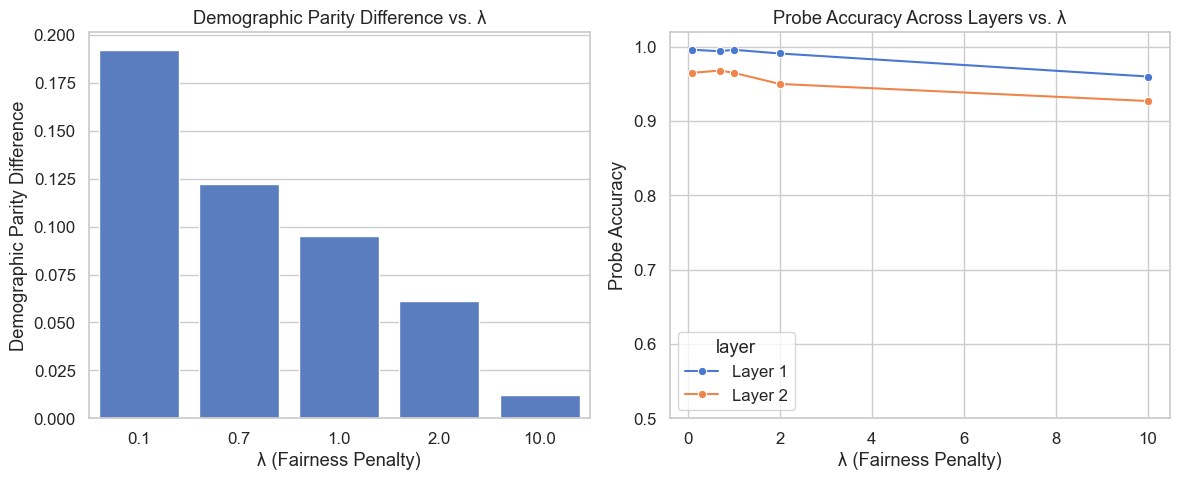

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- Prepare data ---

lambdas = [0.1, 0.7, 1.0, 2.0, 10.0]
dempar_diff = [0.192, 0.122, 0.095, 0.061, 0.012]
probe_acc_l1 = [0.996, 0.994, 0.996, 0.991, 0.960]
probe_acc_l2 = [0.965, 0.968, 0.965, 0.950, 0.927]

# Flatten for seaborn long-form format
probe_df = pd.DataFrame({
    "lambda": lambdas * 2,
    "accuracy": probe_acc_l1 + probe_acc_l2,
    "layer": ["Layer 1"] * len(lambdas) + ["Layer 2"] * len(lambdas)
})
dp_df = pd.DataFrame({
    "lambda": lambdas,
    "DemParDiff": dempar_diff
})

# --- Plot setup ---

sns.set(style="whitegrid", palette="muted", font_scale=1.1)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 📌 Left: Bar plot of DemParDiff
sns.barplot(data=dp_df, x="lambda", y="DemParDiff", ax=axes[0])
axes[0].set_title("Demographic Parity Difference vs. λ")
axes[0].set_ylabel("Demographic Parity Difference")
axes[0].set_xlabel("λ (Fairness Penalty)")

# 📌 Right: Line plot of Probe Accuracies
sns.lineplot(data=probe_df, x="lambda", y="accuracy", hue="layer", marker="o", ax=axes[1])
axes[1].set_title("Probe Accuracy Across Layers vs. λ")
axes[1].set_ylabel("Probe Accuracy")
axes[1].set_xlabel("λ (Fairness Penalty)")
axes[1].set_ylim(0.5, 1.02)

plt.tight_layout()
plt.show()

In [40]:
from sklearn.manifold import TSNE
import umap
import matplotlib.pyplot as plt
import seaborn as sns

gender = test_oh["sex"].values 

# Choose method: either TSNE or UMAP
def reduce_dim(X, method="tsne"):
    if method == "tsne":
        reducer = TSNE(n_components=2, random_state=42, perplexity=30)
    elif method == "umap":
        reducer = umap.UMAP(n_components=2, random_state=42)
    return reducer.fit_transform(X)

# Project both layers
proj_h1 = reduce_dim(h1, method="tsne")  # or "umap"
proj_h2 = reduce_dim(h2, method="tsne")

# Make a dataframe for seaborn
import pandas as pd

def make_df(emb, gender, layer_name):
    return pd.DataFrame({
        "x": emb[:, 0],
        "y": emb[:, 1],
        "gender": ["Male" if g == 1 else "Female" for g in gender],
        "layer": layer_name
    })

df_h1 = make_df(proj_h1, gender, "Layer 1")
df_h2 = make_df(proj_h2, gender, "Layer 2")
df_all = pd.concat([df_h1, df_h2], ignore_index=True)

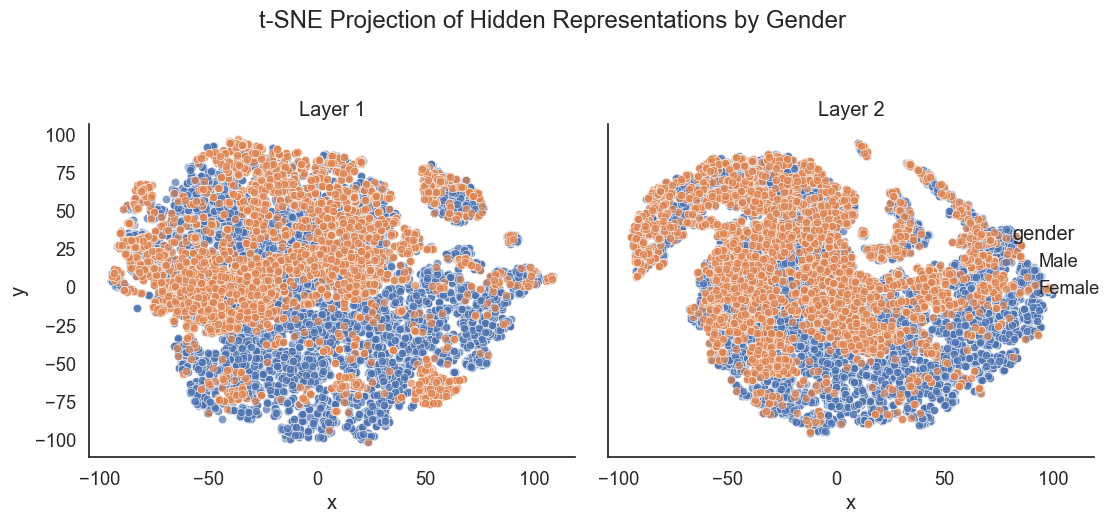

In [41]:
sns.set(style="white", font_scale=1.2)
g = sns.FacetGrid(df_all, col="layer", hue="gender", height=5, aspect=1)
g.map_dataframe(sns.scatterplot, x="x", y="y", alpha=0.7)
g.add_legend()
g.set_titles(col_template="{col_name}")
plt.suptitle("t-SNE Projection of Hidden Representations by Gender", y=1.05)
plt.tight_layout()
plt.show()

In [12]:
from sklearn.manifold import TSNE
import umap
import matplotlib.pyplot as plt
import seaborn as sns

gender = test_oh["sex"].values 

# Step 1: Save a reference to the original (unpatched) fit
true_original_fit = umap.umap_.UMAP.__dict__['fit']  # not umap.UMAP.fit!

# Step 2: Define the patched version
def patched_fit(self, *args, **kwargs):
    kwargs.pop("ensure_all_finite", None)
    return true_original_fit(self, *args, **kwargs)

# Step 3: Apply the patch
umap.umap_.UMAP.fit = patched_fit


reducer = umap.UMAP(n_components=2, random_state=42)
proj_h1 = reducer.fit_transform(h1)

reducer = umap.UMAP(n_components=2, random_state=42)
proj_h2 = reducer.fit_transform(h2)



# Make a dataframe for seaborn
import pandas as pd

def make_df(emb, gender, layer_name):
    return pd.DataFrame({
        "x": emb[:, 0],
        "y": emb[:, 1],
        "gender": ["Male" if g == 1 else "Female" for g in gender],
        "layer": layer_name
    })

df_h1 = make_df(proj_h1, gender, "Layer 1")
df_h2 = make_df(proj_h2, gender, "Layer 2")
df_all = pd.concat([df_h1, df_h2], ignore_index=True)

/Users/clarakumpel/anaconda3/envs/cil/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/clarakumpel/anaconda3/envs/cil/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


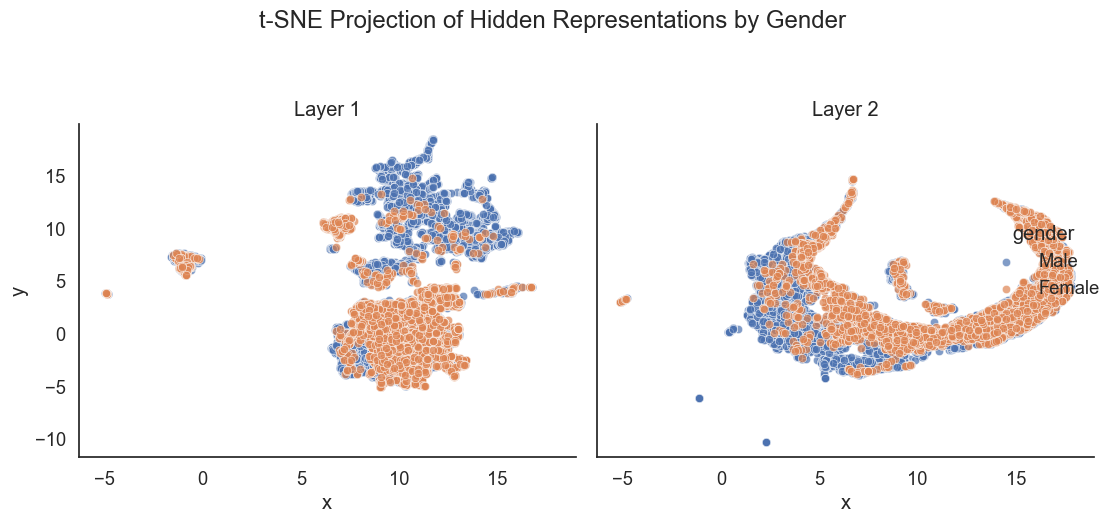

In [13]:
sns.set(style="white", font_scale=1.2)
g = sns.FacetGrid(df_all, col="layer", hue="gender", height=5, aspect=1)
g.map_dataframe(sns.scatterplot, x="x", y="y", alpha=0.7)
g.add_legend()
g.set_titles(col_template="{col_name}")
plt.suptitle("t-SNE Projection of Hidden Representations by Gender", y=1.05)
plt.tight_layout()
plt.show()

## Demographic parity

We measure demographic parity using both the difference and ratio of acceptance rates. These metrics are implemented for us in the `fairlearn` library.

We also compare the distribution of scores for each sex using box plots of scores.

In [69]:
dpd = demographic_parity_difference(
    test_oh.salary, test_pred, sensitive_features=test_oh.sex,
)
dpr = demographic_parity_ratio(
    test_oh.salary, test_pred, sensitive_features=test_oh.sex,
)

print(f"Demographic parity difference: {dpd:.3f}")
print(f"Demographic parity ratio: {dpr:.3f}")

Demographic parity difference: 0.122
Demographic parity ratio: 0.469


In [35]:
fig_dp_by_sex = group_box_plots(
    test_prob,
    test.sex.map(lambda x: "Male" if x else "Female"),
    title="Distribution of scores by sex",
    xlabel="Score",
)
fig_dp_by_sex

We calculate similar metrics and produce similar plots for race.

In [70]:
dpd = demographic_parity_difference(
    test_oh.salary, test_pred, sensitive_features=test.race,
)
dpr = demographic_parity_ratio(
    test_oh.salary, test_pred, sensitive_features=test.race,
)

print(f"Demographic parity difference: {dpd:.3f}")
print(f"Demographic parity ratio: {dpr:.3f}")

Demographic parity difference: 0.180
Demographic parity ratio: 0.251


In [37]:
race_names = {
    "amer_indian_eskimo": "American Indian / Eskimo",
    "asian_pac_islander": "Asian / Pacific Islander",
    "black": "Black",
    "other": "Other",
    "white": "White",
}

fig_dp_by_race = group_box_plots(
    test_prob,
    test.race.map(race_names),
    title="Distribution of scores by race",
    xlabel="Score",
)
fig_dp_by_race

## Conditional demographic parity

Distribution by sex and hours worked per week.

In [53]:
test_hpw_enum = test.hours_per_week.map(bin_hours_per_week)

cdpd = conditional_demographic_parity_difference(
    test_oh.salary, test_pred, test.sex, test_hpw_enum,
)
cdpr = conditional_demographic_parity_ratio(
    test_oh.salary, test_pred, test.sex, test_hpw_enum,
)

print(f"Conditional demographic parity difference: {cdpd:.3f}")
print(f"Conditional demographic parity ratio: {cdpr:.3f}")

Conditional demographic parity difference: 0.028
Conditional demographic parity ratio: 0.750


In [54]:
fig_cdp_by_sex = group_box_plots(
    test_prob,
    test.sex.map(lambda x: "Male" if x else "Female"),
    groups=test_hpw_enum,
    group_names=["0-30", "30-40", "40-50", "50+"],
    title="Distribution of scores by sex and hours worked per week",
    xlabel="Score",
    ylabel="Hours worked per week",
)
fig_cdp_by_sex

Distribution by race and hours worked per week.

In [55]:
cdpd = conditional_demographic_parity_difference(
    test_oh.salary, test_pred, test.race, test_hpw_enum,
)
cdpr = conditional_demographic_parity_ratio(
    test_oh.salary, test_pred, test.race, test_hpw_enum,
)

print(f"Conditional demographic parity difference: {cdpd:.3f}")
print(f"Conditional demographic parity ratio: {cdpr:.3f}")

Conditional demographic parity difference: 0.218
Conditional demographic parity ratio: 0.077


In [56]:
fig_cdp_by_race = group_box_plots(
    test_prob,
    test.race.map(race_names),
    groups=test_hpw_enum,
    group_names=["0-30", "30-40", "40-50", "50+"],
    title="Distribution of scores by race and hours worked per week",
    xlabel="Score",
    ylabel="Hours worked per week",
)
fig_cdp_by_race

## Equalised odds

To assess equalised odds we compare scores across the outcome classes.

In [71]:
eod = equalized_odds_difference(
    test_oh.salary, test_pred, sensitive_features=test.sex,
)
eor = equalized_odds_ratio(
    test_oh.salary, test_pred, sensitive_features=test.sex,
)

print(f"Equalised odds difference: {eod:.3f}")
print(f"Equalised odds ratio: {eor:.3f}")

Equalised odds difference: 0.067
Equalised odds ratio: 0.519


In [58]:
fig_eo_by_sex = group_box_plots(
    test_prob,
    test.sex.map(lambda x: "Male" if x else "Female"),
    groups=test.salary,
    group_names=["Low earner", "High earner"],
    title="Distribution of scores by sex for high and low earners",
    xlabel="Score",
    ylabel="High / low earner",
)
fig_eo_by_sex

We do the same, comparing races.

In [72]:
eod = equalized_odds_difference(
    test_oh.salary, test_pred, sensitive_features=test.race,
)
eor = equalized_odds_ratio(
    test_oh.salary, test_pred, sensitive_features=test.race,
)

print(f"Equalised odds difference: {eod:.3f}")
print(f"Equalised odds ratio: {eor:.3f}")

Equalised odds difference: 0.328
Equalised odds ratio: 0.255


In [60]:
fig_eo_by_race = group_box_plots(
    test_prob,
    test.race.map(race_names),
    groups=test.salary,
    group_names=["Low earner", "High earner"],
    title="Distribution of scores by race for high and low earners",
    xlabel="Score",
    ylabel="High / low earner",
)
fig_eo_by_race